In [1]:
# Increase cell widths to be able to visualize the aligned-edits columns properly

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_113374/3452212369.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1]:
from datasets import load_dataset, list_metrics, load_metric

# df_train = load_dataset("GroNLP/ik-nlp-22_pestyle", "full", data_dir="IK_NLP_22_PESTYLE")['train'].to_pandas()

In [20]:
# Check how many translations were performed by each translator
translators = df_train.subject_id.unique()
modalities = df_train.modality.unique()
for idx, t in enumerate(translators):
    modality_counts = list(df_train[df_train.subject_id == t].modality.value_counts())
    print(modality_counts)

[143, 125, 122]
[143, 125, 122]
[143, 125, 122]


In [21]:
stats = {t: {m: {} for m in modalities} for t in translators}

### Get average properties per modality per translator

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

columns_of_interest = ['edit_time', 'k_total', 'n_pause_geq_300', 'n_pause_geq_1000', 'n_insert', 'n_delete',
                      'n_substitute', 'n_shift', 'bleu', 'chrf', 'ter']
for t in translators:
    for m in modalities:
        curr_df = df_train[(df_train.subject_id == t) & (df_train.modality == m)]
        for col in columns_of_interest:
            stats[t][m][f'avg_{col}'] = np.mean(curr_df[col])

def plot_bars(stats: pd.DataFrame, stat_type):
    fig, ax = plt.subplots(1,3, figsize=(16,5))
    fig.tight_layout(h_pad=2)
    
    stats_flat = []
    for idx, m in enumerate(modalities):
        stat_per_mod = []
        for t in stats.keys():
            stat_per_mod.append(stats[t][m][stat_type])
            if stats[t][m][stat_type] > 0:
                stats_flat.append(stats[t][m][stat_type])
            else:
                stats_flat.append(0)
        ax[idx].bar(list(range(len(modalities))), height=stat_per_mod, width=0.9)    
        ax[idx].set_title(f'{stat_type.capitalize()} for modality {m}')
        ax[idx].set_ylim(0, max(stats_flat)*1.1)

/tmp/ipykernel_149796/238699269.py:28: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax[idx].set_ylim(0, max(stats_flat)*1.1)


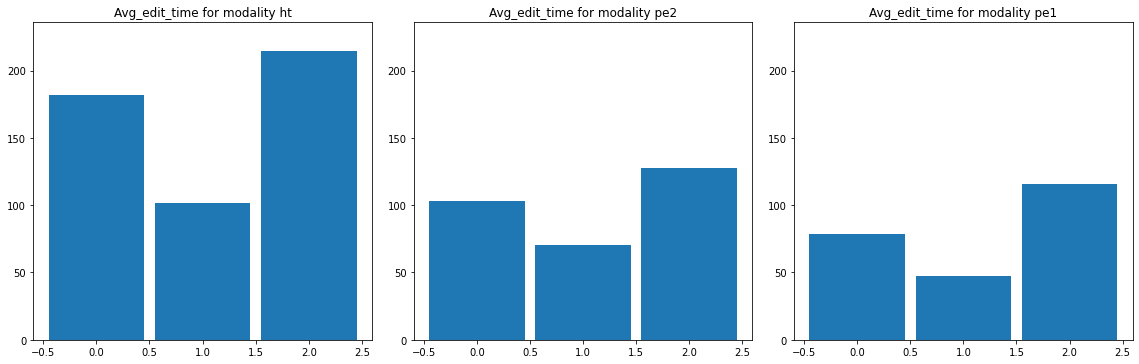

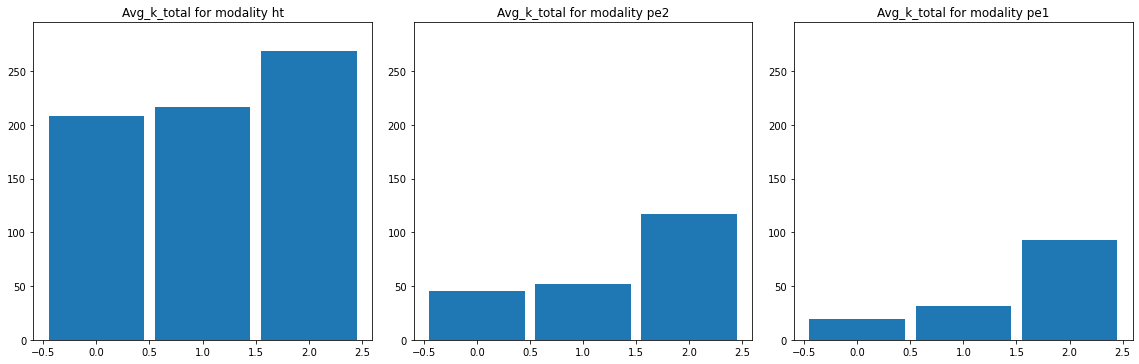

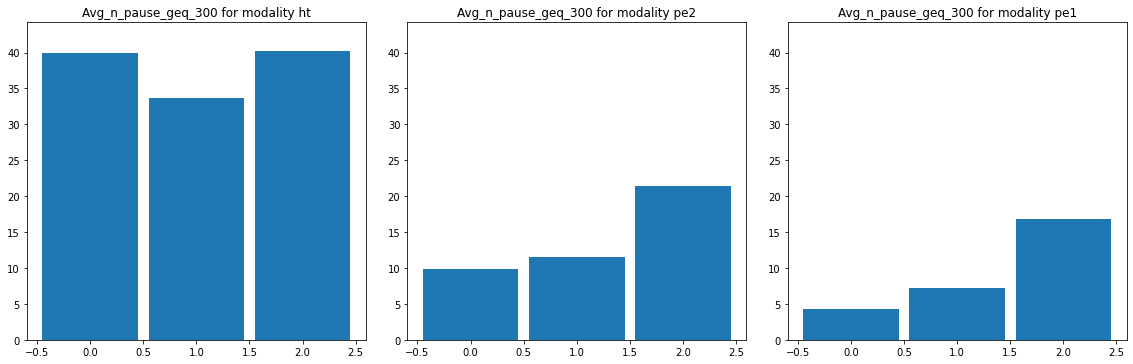

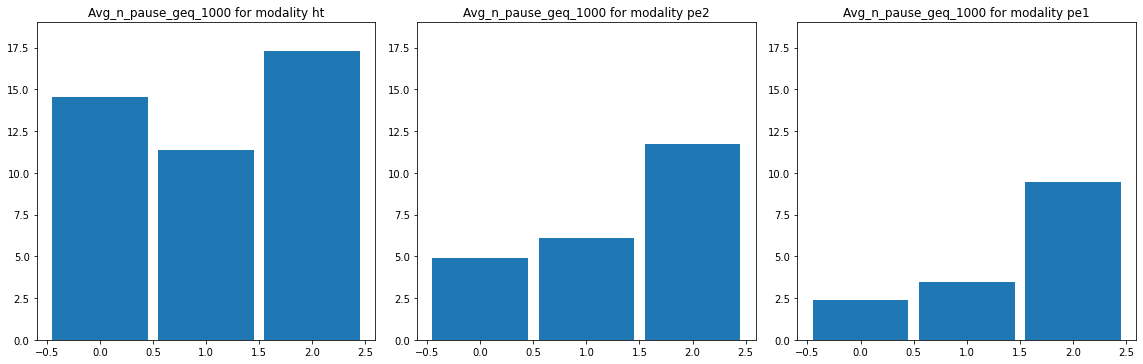

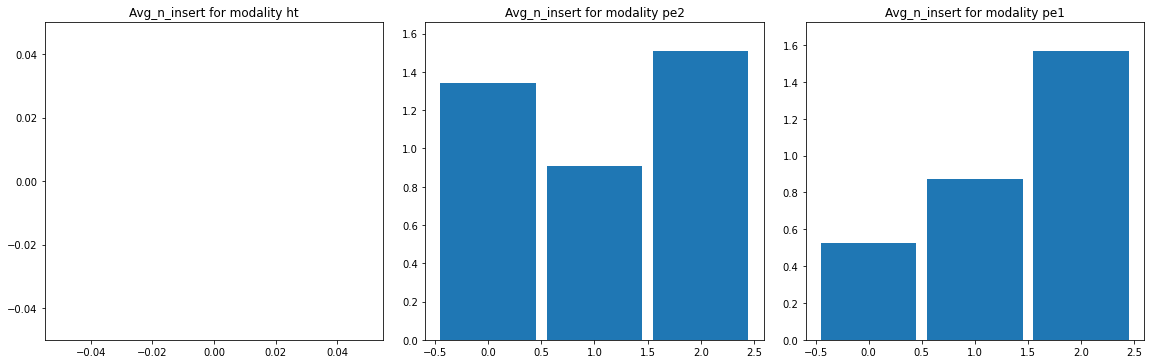

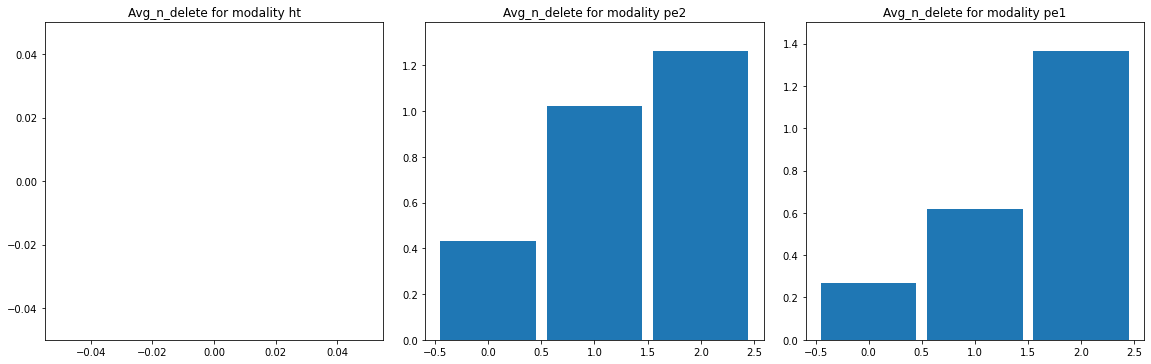

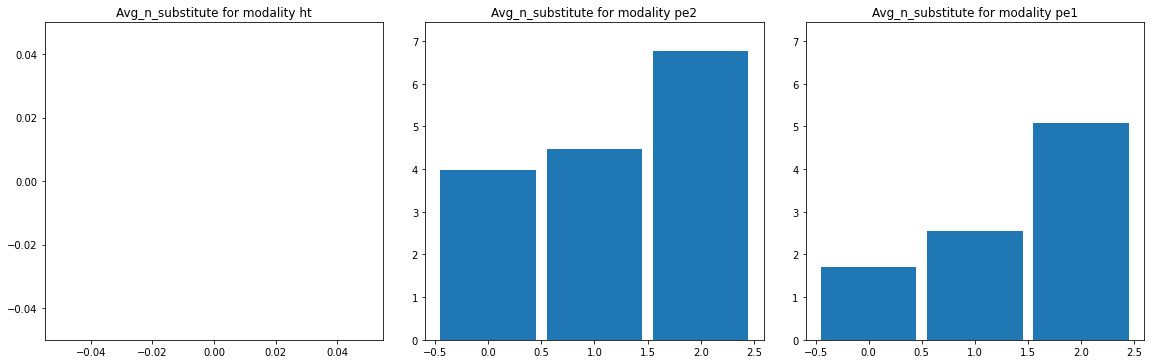

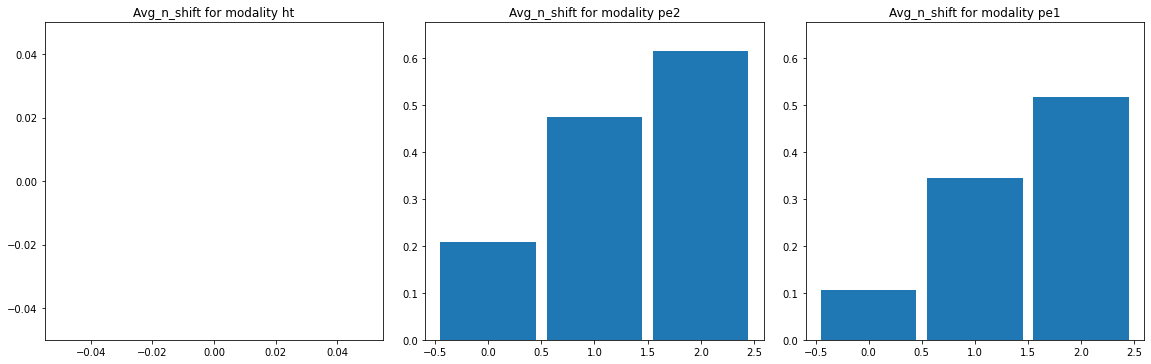

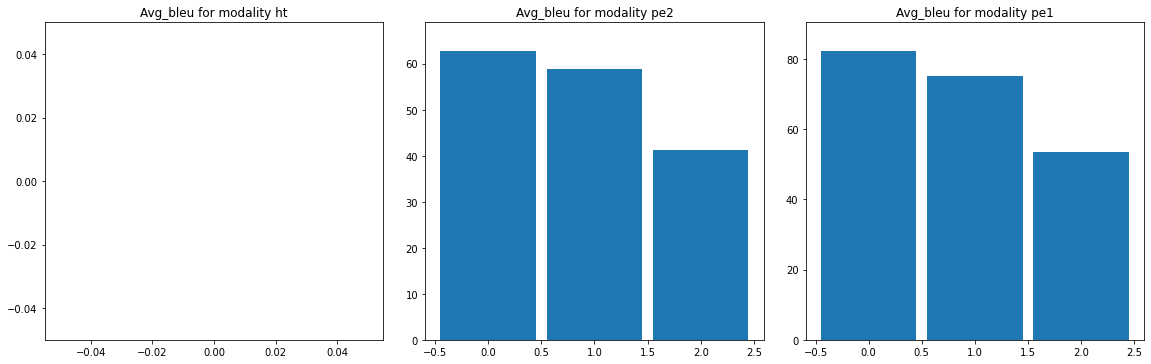

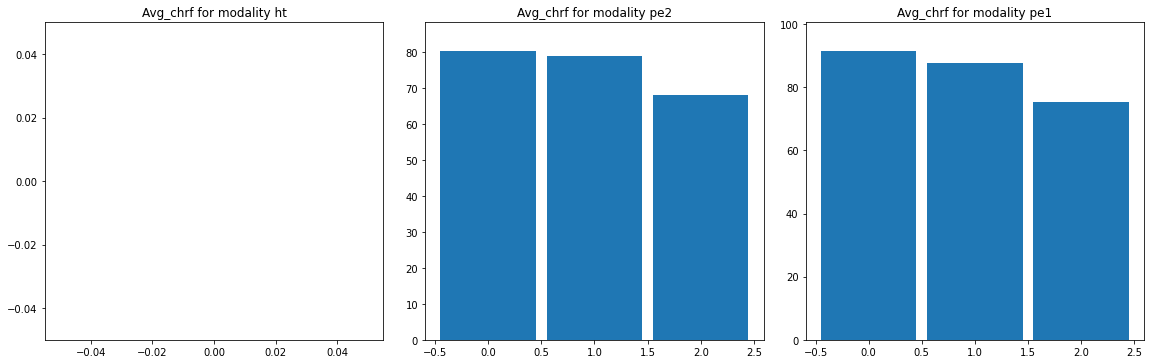

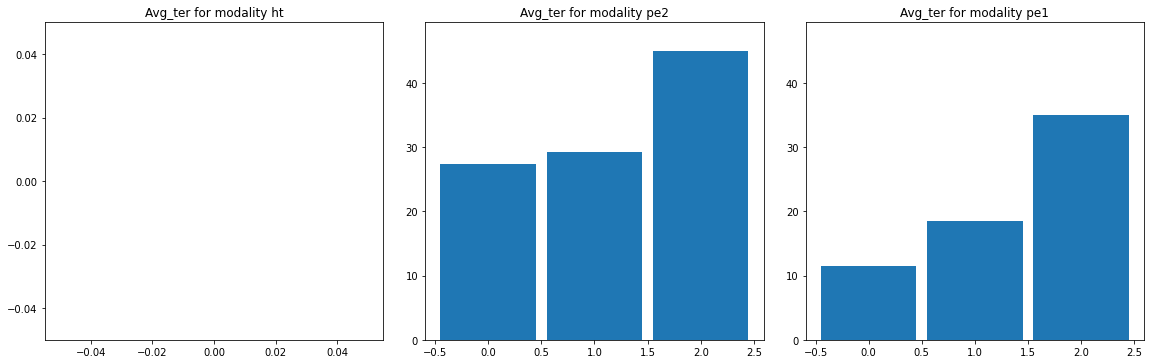

In [23]:
for col in columns_of_interest:
    plot_bars(stats, f'avg_{col}')

### Compute pairwise correlation of columns, excluding NA/null values.

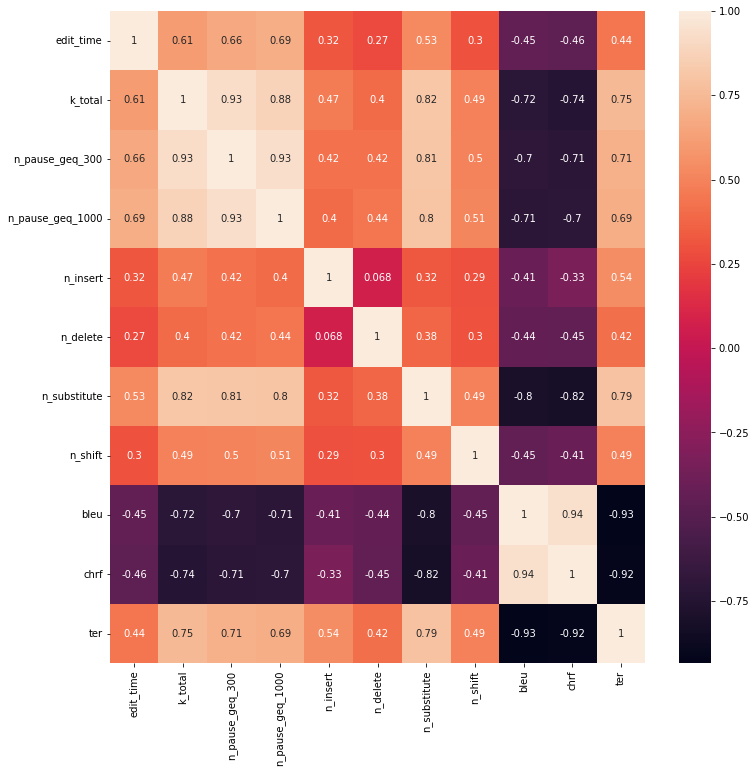

In [24]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(df_train[columns_of_interest].corr(), annot=True)

## Create a Transition Matrix for each translator, based on POS tags of machine translated and post-edited sentences

In [25]:
!python3 -m spacy download it_core_news_sm
!python3 -m spacy download en_core_web_sm

/home/peter/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
/home/peter/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [26]:
import spacy

nlp_it = spacy.load("it_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

### Print an example to get an idea how aligned-edit fields look like

In [27]:
print(df_train.aligned_edit[1].replace('\\n', '\n'))

REF:  i  soldati della pace dell'onu, che     sono   arrivati ad haiti dopo il terremoto del 2010, sono stati incolpati per   la   diffusione della     malattia che è iniziata vicino al     campo             delle truppe.
HYP:  le forze   di    pace delle     nazioni unite, arrivate ad haiti dopo il terremoto del 2010, sono state accusate  di  [ la ] aver       diffuso @ malattia *** * iniziata nei    pressi dell'accampamento delle truppe.
EVAL: S  S       S          S         S       S      S                                                  S     S         S          S          S                  D   D          S      S      S


### Step 0 ) Optional: Add POS features as separate columns to the df_train dataframe, of the "mt" and "tgt" sentences

In [28]:
df_pe = df_train[df_train.mt_text != 'nan']
df_pe.name = "DataFrame of Post-Edited rows"

pos_tags_mt = [np.NaN for i in range(len(df_train))]
pos_tags_tgt = [np.NaN for i in range(len(df_train))]
for idx, row in df_pe.iterrows():
    pos_tags_mt[idx] = [tok.pos_ for tok in nlp_it(row.mt_text)]
    pos_tags_tgt[idx] = [tok.pos_ for tok in nlp_it(row.tgt_text)]
print(len(pos_tags_mt) == len(pos_tags_tgt) == len(df_train))

True


In [29]:
df_train = pd.concat([df_train, pd.Series(pos_tags_mt, name='POS_mt'), pd.Series(pos_tags_tgt, name='POS_tgt')], axis=1)

In [30]:
df_train

,item_id,subject_id,modality,src_text,mt_text,tgt_text,edit_time,k_total,k_letter,k_digit,...,n_insert,n_delete,n_substitute,n_shift,bleu,chrf,ter,aligned_edit,POS_mt,POS_tgt
0,11,t1,ht,"UN peacekeepers, whom arrived in Haiti after t...",nan,"I corpi di pace armati delle Nazioni Unite, ch...",149.979996,268,204,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN
1,11,t2,pe2,"UN peacekeepers, whom arrived in Haiti after t...","I soldati della pace dell'ONU, che sono arriva...","Le forze di pace delle Nazioni Unite, arrivate...",128.078995,179,102,0,...,0.0,2.0,15.0,1.0,29.290001,56.939999,58.064999,"REF: i soldati della pace dell'onu, che ...","[DET, NOUN, ADP, NOUN, ADP, PROPN, PUNCT, PRON...","[DET, NOUN, ADP, NOUN, ADP, PROPN, PROPN, PUNC..."
2,11,t3,pe1,"UN peacekeepers, whom arrived in Haiti after t...","Le forze di pace delle Nazioni Unite, arrivate...","Le forze di pace dell'ONU, arrivate ad Haiti d...",141.500000,57,27,0,...,1.0,2.0,2.0,0.0,74.660004,84.959999,18.518999,"REF: le forze di pace delle nazioni unite, ...","[DET, NOUN, ADP, NOUN, ADP, PROPN, PROPN, PUNC...","[DET, NOUN, ADP, NOUN, ADP, PROPN, PUNCT, VERB..."
3,12,t1,ht,"According to the lawsuit, waste from the UN ca...",nan,"Secondo la causa, i rifiuti derivanti dal camp...",151.317993,276,210,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN
4,12,t2,pe2,"According to the lawsuit, waste from the UN ca...","Secondo la causa, i rifiuti del campo delle Na...","Secondo l'accusa, i rifiuti del campo delle Na...",66.817001,67,52,0,...,2.0,1.0,4.0,0.0,65.480003,83.419998,25.000000,"REF: secondo la causa, i rifiuti del campo...","[ADP, DET, NOUN, PUNCT, DET, NOUN, ADP, NOUN, ...","[ADP, DET, NOUN, PUNCT, DET, NOUN, ADP, NOUN, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1073,t2,ht,"However, due to the slow communication channel...",nan,"Tuttavia, a causa dei lenti canali di comunica...",61.193001,147,104,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN
1166,1073,t3,pe2,"However, due to the slow communication channel...","Tuttavia, a causa dei canali di comunicazione ...","Tuttavia, per via di canali di comunicazione l...",143.360001,69,37,0,...,1.0,0.0,8.0,0.0,43.189999,65.019997,47.368000,"REF: tuttavia, a causa dei canali di comuni...","[ADV, PUNCT, ADP, NOUN, ADP, NOUN, ADP, NOUN, ...","[ADV, PUNCT, ADP, NOUN, ADP, NOUN, ADP, NOUN, ..."
1167,1074,t1,pe1,towards the end of the Middle Ages western Eur...,verso la fine del Medioevo l'Europa occidental...,"Verso la fine del Medioevo, l'Europa occidenta...",154.690002,36,22,0,...,2.0,0.0,3.0,0.0,68.160004,90.050003,14.286000,REF: verso la fine del medioevo l'europa occ...,"[ADP, DET, NOUN, ADP, NOUN, DET, PROPN, ADJ, V...","[ADP, DET, NOUN, ADP, PROPN, PUNCT, DET, PROPN..."
1168,1074,t2,ht,towards the end of the Middle Ages western Eur...,nan,"Verso la fine del Medioevo, l'Europa occidenta...",182.785995,348,244,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN


### Step 1) Functions for retrieving basic information about spaCy Doc-s and for retrieving pairwise POS tags for the sentence-pairs' tokens

In [31]:
def print_attributes(doc_or_span):
    print("Text\t\tLemma\t\tUPOS\t\tXPOS\t\tDEP\t\tShape\t\tIsAlpha\t\tIsStop\t\tIsPunct\t\tIsAscii\n" + "-"*80)
    for token in doc_or_span:
        print(
            f"{token.text.strip()}\t\t{token.lemma_.strip()}\t\t{token.pos_}\t\t{token.tag_}\t\t"
            f"{token.dep_}\t\t{token.shape_}\t\t{token.is_alpha}\t\t"
            f"{token.is_stop}\t\t{token.is_punct}\t\t{token.is_ascii}"
        )

def check_iterables(function):
    """Decorator that checks whether length of two iterables are the same or not, and whether the supplied arguments are actually iterables or not."""
    def wrapper(*args, **kwargs):
        assert len(args) == 2, "Expected number of iterables is two."
        for arg in args:
            assert hasattr(arg, '__iter__'), f"Argument '{arg}' is not an iterable."
        assert len(args[0]) == len(args[1]), "Length of two iterables is not the same, creating pairwise tuples will omit elements from the longer iterable."
        return function(*args, **kwargs)
    return wrapper
    

@check_iterables
def get_pos_tags(doc1, doc2):
    """Retrieves all the POS tags of a given doc pair into a list of tuples."""
    return [(tok1.pos_, tok2.pos_) for tok1, tok2 in zip(doc1, doc2)]

@check_iterables
def get_idx_pair(l1, l2):
    """Returns the elements of two lists that belong to the same index in tuples of pairs, e.g. [tuple(l1[0], l2[0]), tuple(l1[1], l2[1])]"""
    pairs = [(e1, e2) for e1, e2 in zip(l1, l2)]
    return pairs
    

idx_0 = df_pe.index[0]  # first index in the "df_pe" dataframe --> "0" itself might not be present due to the indices not being reset after row filtering

# Test if decorator works nor not
try:
    get_pos_tags(nlp_en(df_pe.mt_text[idx_0]), nlp_it(df_pe.tgt_text[idx_0]))
except AssertionError as error:
    print(error)
    
try:
    print(get_idx_pair([1,2,3,4], [134, "hello", [1341], 0.314]))
except AssertionError as error:
    print(error)

Length of two iterables is not the same, creating pairwise tuples will omit elements from the longer iterable.
[(1, 134), (2, 'hello'), (3, [1341]), (4, 0.314)]


In [32]:
print_attributes(nlp_it(df_pe.iloc[0].aligned_edit.split('\\n')[0]))

Text		Lemma		UPOS		XPOS		DEP		Shape		IsAlpha		IsStop		IsPunct		IsAscii
--------------------------------------------------------------------------------
REF		ref		PROPN		SP		ROOT		XXX		True		False		False		True
:		:		PUNCT		FC		punct		:		False		False		True		True
				SPACE		_SP		dep		 		False		False		False		True
i		il		DET		RD		det		x		True		False		False		True
				SPACE		_SP		dep		 		False		False		False		True
soldati		soldato		NOUN		S		obj		xxxx		True		False		False		True
della		della		ADP		E_RD		case		xxxx		True		True		False		True
pace		pace		NOUN		S		nmod		xxxx		True		False		False		True
dell'		dell'		ADP		E_RD		case		xxxx'		False		False		False		True
onu		onu		PROPN		SP		nmod		xxx		True		False		False		True
,		,		PUNCT		FF		punct		,		False		False		True		True
che		che		PRON		PR		nsubj		xxx		True		True		False		True
				SPACE		_SP		dep		    		False		False		False		True
sono		essere		AUX		V		cop		xxxx		True		True		False		True
				SPACE		_SP		dep		  		False		False		False		True
arrivati		arrivare

In [33]:
import re
import pprint

POS_tags = {'t1': [], 't2': [], 't3': []}
stop_words_and_puncts = {'t1': [], 't2': [], 't3': []}
for idx, row in df_pe.iterrows():
    edits = row.aligned_edit.split('\\n')
    if len(edits) == 3:  # include those 'edits' too that had no actual edits (e.g. correct translation), so that the number of elements within the POS_tags list remains the same as the length of 'df_pe'
        ref, hyp, eva, = edits[0], edits[1], edits[2]
        edit_idx = [m.start() for m in re.finditer('S|D|I', eva)]
        
        ref_tags = []
        hyp_tags = []
        for i in range(len(edit_idx)):
            if i+1 < len(edit_idx):
                ref_tags.append(ref[edit_idx[i]:edit_idx[i+1]].split()[0])
                hyp_tags.append(hyp[edit_idx[i]:edit_idx[i+1]].split()[0])
            else:
                ref_tags.append(ref[edit_idx[i]:].split()[0])
                hyp_tags.append(hyp[edit_idx[i]:].split()[0])
        ref_tags_tokenized = [[tok.pos_ for tok in nlp_it(word)] for word in ref_tags]
        ref_tag_flags = [[all([not tok.is_stop, not tok.is_punct]) for tok in nlp_it(word)] for word in ref_tags]
        hyp_tags_tokenized = [[tok.pos_ for tok in nlp_it(word)] for word in hyp_tags]
        hyp_tag_flags = [[all([not tok.is_stop, not tok.is_punct]) for tok in nlp_it(word)] for word in hyp_tags]
        
        POS_tags[row.subject_id].append(get_idx_pair(ref_tags_tokenized, hyp_tags_tokenized))
        stop_words_and_puncts[row.subject_id].append(get_idx_pair(ref_tag_flags, hyp_tag_flags))
    else:
        raise TypeError(f"'aligned_edit' column is missing from row '{idx}' of the dataframe.")

assert sum([len(sublist) for sublist in list(POS_tags.values())]) == len(df_pe), f"Length mismatch between 'POS_tags' list and [{df_pe.name}]"
assert sum([len(sublist) for sublist in list(stop_words_and_puncts.values())]) == len(df_pe), f"Length mismatch between 'stop_words_and_puncts' list and [{df_pe.name}]"

In [39]:
POS_tags['t1'][2]

[(['ADV'], ['PUNCT', 'PUNCT', 'PUNCT', 'PUNCT', 'PUNCT', 'PUNCT']),
 (['CCONJ'], ['ADP']),
 (['ADV'], ['VERB']),
 (['NOUN'], ['NOUN'])]

In [35]:
stop_words_and_puncts['t1'][2]

[([False], [False, False, False, False, False, False]),
 ([True], [False]),
 ([True], [True]),
 ([True], [True])]

## Step 2) Accumulate occurences of transition types for each translator

In [36]:
# GET UPOS tags from https://universaldependencies.org/u/pos/ into a dictionary
UPOS_tags = """ADJ: adjective
    ADP: adposition
    ADV: adverb
    AUX: auxiliary
    CCONJ: coordinating conjunction
    DET: determiner
    INTJ: interjection
    NOUN: noun
    NUM: numeral
    PART: particle
    PRON: pronoun
    PROPN: proper noun
    PUNCT: punctuation
    SCONJ: subordinating conjunction
    SYM: symbol
    VERB: verb
    X: other"""
strip_split = lambda x: x.strip().split(':')
UPOS_tags = {strip_split(tag)[0]: strip_split(tag)[1].strip() for tag in UPOS_tags.split("\n")}
UPOS_tags

{'ADJ': 'adjective',
 'ADP': 'adposition',
 'ADV': 'adverb',
 'AUX': 'auxiliary',
 'CCONJ': 'coordinating conjunction',
 'DET': 'determiner',
 'INTJ': 'interjection',
 'NOUN': 'noun',
 'NUM': 'numeral',
 'PART': 'particle',
 'PRON': 'pronoun',
 'PROPN': 'proper noun',
 'PUNCT': 'punctuation',
 'SCONJ': 'subordinating conjunction',
 'SYM': 'symbol',
 'VERB': 'verb',
 'X': 'other'}

In [4]:
df_test = load_dataset("GroNLP/ik-nlp-22_pestyle", "mask_time", data_dir="../IK_NLP_22_PESTYLE")['test'].to_pandas()

Using custom data configuration mask_time-data_dir=..%2FIK_NLP_22_PESTYLE


0 examples [00:00, ? examples/s]

Dataset ik_nlp22_pe_style downloaded and prepared to /home/peter/.cache/huggingface/datasets/GroNLP___ik_nlp22_pe_style/mask_time-data_dir=..%2FIK_NLP_22_PESTYLE/1.0.0/3bbf0fda4806257149c2beb42c6cd20db6f79dac9ae2498f44be55fa7a953d51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_test[df_test.modality != 'ht'].subject_id.to_csv('test_ground_truths.csv', sep=",", header=False, index=False)